# Bounds on the number of samples of size $k$ from a population of size $n$ for various PRNGs and sampling algorithms

This notebook uses entropy-based bounds to find upper bounds on the number of samples that can be generated using a variety of algorithms for generating pseudo-random numbers (PRNs) and for turning sequences of PRNs into samples.

+ a hypothetical sampling algorithm that uses an optimal coding of samples to turn strings of $\log_2{n \choose k}$ bits into samples of size $k$
+ a common algorithm that involves assigning a PRN to each of the $n$ elements, then taking those elements assigned the smallest $k$ numbers to be the sample
+ algorithm R, a streamable algorithm that also uses at least one PRN per element of the population, but avoids the sort.
+ algorithm S of Knuth, another reservoir method
+ algorithm Random-Sample on p. 130 of [Cormen et al. (2009)](https://mitpress.mit.edu/books/introduction-algorithms)

PRNGs considered include [linear congruential generators](https://en.wikipedia.org/wiki/Linear_congruential_generator) (LCGs, including [RANDU](https://en.wikipedia.org/wiki/RANDU)), and the [Mersenne Twister](https://en.wikipedia.org/wiki/Mersenne_Twister). The behavior of the [middle square method](https://en.wikipedia.org/wiki/Middle-square_method) is presumably worse.

[Kellie Ottoboni](http://www.stat.berkeley.edu/~kellieotto/) and [Philip B. Stark](www.stat.berkeley.edu/~stark)



## References

1. Cormen, T.H., C.E. Leiserson, R.L. Rivest and C. Stein, 2009. _Introduction to Algorithms, 3rd edition_, MIT Press
1. Knuth, D., 1997 _The Art of Computer Programming, V.II: Seminumerical methods_, 3rd edition, Addison-Wesley, Boston.
1. Shannon, C.E., 1948. A Mathematical Theory of Communication, _Bell System Technical Journal, 27_, 379&ndash;423, 623&ndash;656. 
1. Vitter, J.S., 1985. Random Sampling with a Reservoir, _ACM Transactions on Mathematical Software, 11_, 37&ndash;57.
1. Wikipedia articles

Bound ${n \choose k}$ using the inequality

$$ \frac{2^{nH(k/n)}}{n+1} \le {n \choose k} \le 2^{nH(k/n)}$$


In [1]:
%matplotlib inline
from __future__ import division
import math
import numpy as np
import scipy as sp
from scipy.misc import comb, factorial
from scipy.optimize import brentq
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def H(q):  # entropy of a Bernoulli(q) variable
    return -q*math.log(q, 2) - (1-q)*math.log(1-q, 2)
    

def comb_upper_bound(n, k):  # entropy upper bound on nCk
    q = k/n
    return 2**(n*H(q))


def comb_lower_bound(n, k): # entropy upper bound on nCk
    q = k/n
    return 2**(n*H(q))/(n+1)

In [3]:
# number of bits per period divided by log_2(choose(n,k))?
def sample_counter(n, k, period, word_length):
    return (period*word_length) > math.log(comb(n, k), 2)*comb(n, k)


def sample_counter_lb(n, k, period, word_length):
    ub_bits_for_all_samples = (n*H(k/n) - math.log(n+1, 2))*(2**(n*H(k/n)))/(n+1)
    return (period*word_length) > ub_bits_for_all_samples

# RANDU
The next few computations are specific to the RANDU PRNG, a particularly bad [LCG](https://en.wikipedia.org/wiki/Linear_congruential_generator) promulgated in the 1960s and widely copied.

RANDU is given by the recursion

$$ V_{j+1} = 65539 V_j \mod 2^{31}.$$

Triples of values from RANDU fall on 15 planes in 3-dimensional space, as shown below.

In [4]:
# python implementation of RANDU by pakopa, https://github.com/pakopa/RANDU.py/blob/master/randu.py

class Randu:
    """The infamous RANDU algorithm
    wikipedia: http://en.wikipedia.org/wiki/RANDU
    """

    #Variables for the general formula x(i+1) = A + Bx(i) mod M
    _seed = 0
    _M = 2**31
    _A = 0
    _B = 65539
    
    def __init__(self, seed):
        self._seed = seed
        self._sequencer = self.sequencer()
                        
    def sequencer(self):
        out = self._seed
        while True:
            out = self._A + ((self._B * out) % self._M)
            yield out

    def __iter__(self):
        return self

    def next(self):
        return self._sequencer.next()

In [51]:
# generate triples using RANDU
seed = 1234567890
reps = 100000
r = Randu(seed) 
urandTrips = np.reshape([r.next() for i in range(3*reps)],(reps,3)).T
xs = urandTrips[0]
ys = urandTrips[1]
zs = urandTrips[2]

test = np.reshape([0,1,2,3,4,5,6,7,8,9,10,11],(3,4)).T
print test
testx = test[0][:]
print testx

[[ 0  4  8]
 [ 1  5  9]
 [ 2  6 10]
 [ 3  7 11]]
[0 4 8]


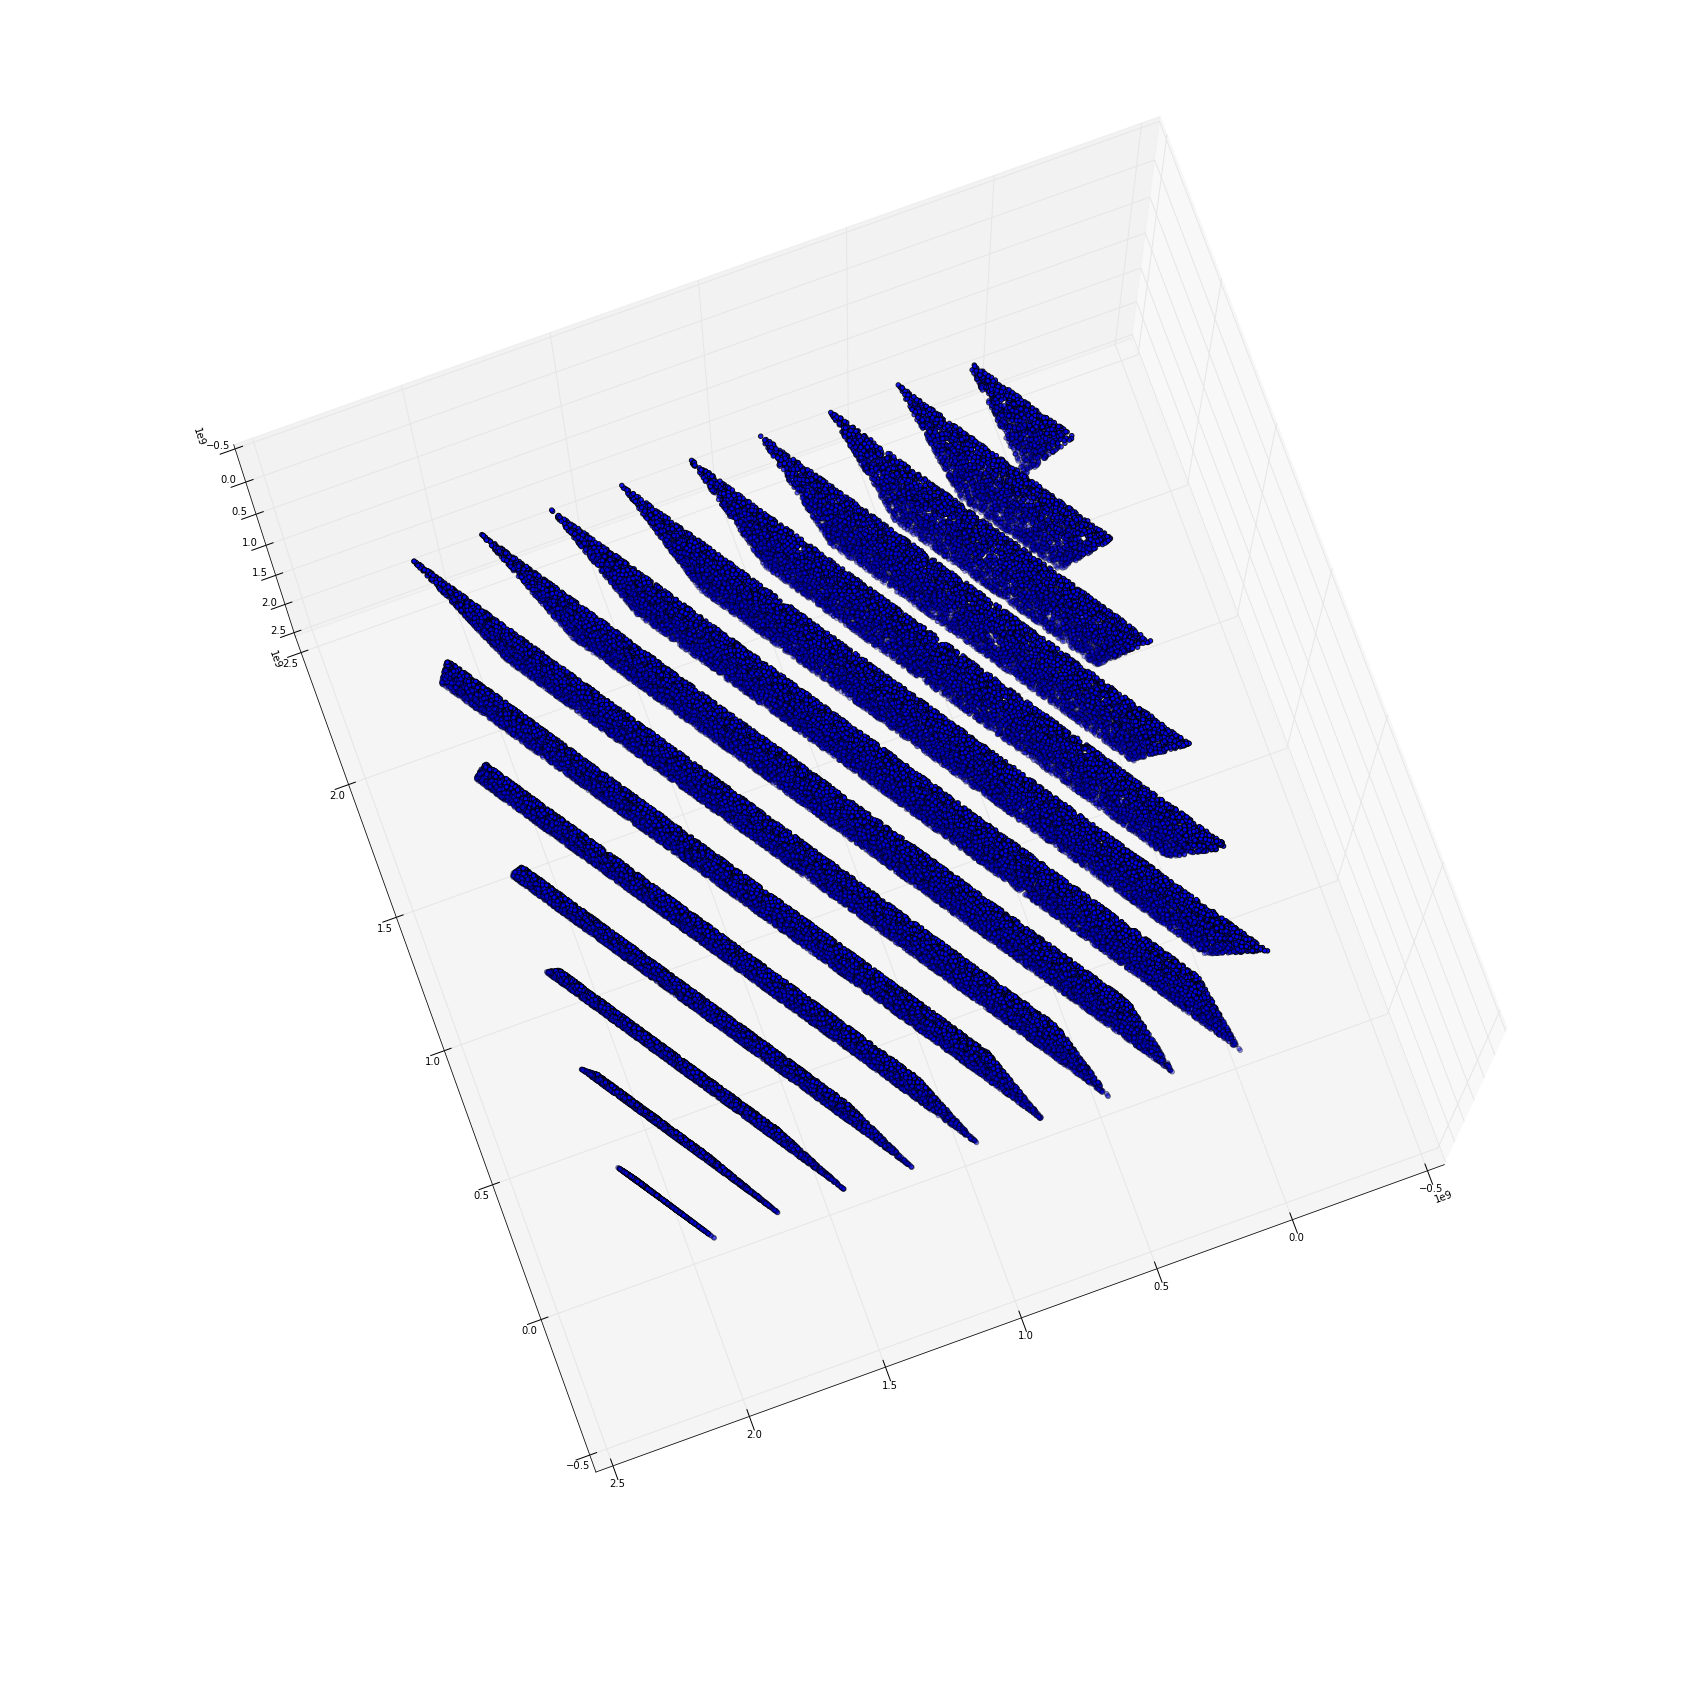

In [52]:
fig = plt.figure()
plt.rcParams['figure.figsize'] = (30.0, 30.0) 
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs)

ax.view_init(-100,110)

plt.show()

In [ ]:
randu_period = 2**29
randu_word_length = 32

In [ ]:
n = 30
k = 20
can_do = True
while can_do:
    n = n+1
    can_do = sample_counter_lb(n, k, randu_period, randu_word_length)
    print n
print "can't do ",n

n = 30
k = 20
can_do = True
while can_do:
    n = n+1
    can_do = sample_counter(n, k, randu_period, randu_word_length)
    print n
print "can't do ",n

# Most efficient coding/a single period of the PRNG

Suppose we generate samples of size $k$ from a population of size $n$.
There are ${n \choose k}$ such samples.
The most efficient coding scheme requires $\log_2{n \choose k}$ bits to encode all possible samples.

A PRNG generates a "word" (typically an integer) using a fixed number of bits.
The period of the PRNG tells us the maximum number of words the PRNG can generate starting from a particular seed.
The period times the word length is the number of random bits that the PRNG can generate.
If this number is less than the number of bits per sample encoding times the number of samples, ${n \choose k}\log_2{n \choose k}$, then it is not possible to generate all possible samples in one period of the PRNG.

For a particular PRNG with known period and word length (typically 32 bits), we can fix $k$ and calculate the largest $n$ for which the PRNG can generate all possible samples.
Similarly, we can fix $n$ and find the largest $k$ for which the PRNG can generate all possible samples.
Note, when we vary $k$ it is only interesting for $1 \leq k \leq \lfloor{\frac{n}{2}}\rfloor$.
Without loss of generality, if $k > \lfloor{\frac{n}{2}}\rfloor$, we can think of the sampling as selecting individuals to *exclude* from the sample.

For large $n$, it's costly to compute binomial coefficients.
Instead, we use the following bound:

$$ \frac{2^{nH(k/n)}}{n+1} \leq {n \choose k} \leq 2^{nH(k/n)}$$

When dealing with the Mersenne Twister, we substitute the lower bound for ${n \choose k}$, giving overly optimistic estimates of maximum $n$.

## RANDU

In [ ]:
k = [20, 50, 100, 500]
maxn = [0, 0, 0, 0]
i = 0
step_size = 10
for kk in k:
    can_do = True
    n = kk
    while can_do:
        n = n + step_size
        can_do = sample_counter_lb(n, kk, randu_period, randu_word_length)
#    print n
    
    count = lambda x: randu_period*randu_word_length - math.log(comb(x, kk), 2)*comb(x, kk)
    if kk==(n-step_size):
        llim = n - step_size + 1
    else:
        llim = n - step_size
    maxn[i] = np.trunc(brentq(count, llim, n))
    i = i + 1
    
print(maxn)

In [ ]:
n = [10, 20, 50, 100]
maxk = [0, 0, 0, 0]
i = 0
step_size = 1
for nn in n:
    can_do = True
    k = 0
    while can_do and k < nn/2:
        k = k + step_size
        can_do = sample_counter(nn, k, randu_period, randu_word_length)
    maxk[i] = k
    i = i + 1
    
print(maxk)

## Mersenne Twister

In [ ]:
mersenne_twister_period = (2**19937) - 1
mersenne_twister_word_length = 32

In [ ]:
n = 100
k = 100
can_do = True
while can_do and n<1000000:
    n = n+1000
    can_do = sample_counter_lb(n, k, mersenne_twister_period, mersenne_twister_word_length)
    print n
print "can't do ",n

In [ ]:
k = [50, 100]
maxn = [0, 0]
i = 0
step_size = 10**4
for kk in k:
    can_do = True
    n = kk
    while can_do:
        n = n + step_size
        can_do = sample_counter_lb(n, kk, mersenne_twister_period, mersenne_twister_word_length)
    
    # This doesn't seem to work. I wonder if it's a problem with long int math.
#    count = lambda x: mersenne_twister_period*mersenne_twister_word_length - long((x*H(kk/x) - math.log(x+1, 2))*(2**(x*H(kk/x))/(x+1)))
#    maxn[i] = brentq(count, n-step_size, n)
    while not can_do:
        n = n - 1
        can_do = sample_counter_lb(n, kk, mersenne_twister_period, mersenne_twister_word_length)
    maxn[i] = n
    i = i + 1
    step_size = step_size/100
print maxn

# Naive Sampling Algorithm

The "naive sampling algorithm" is the algorithm that assigns a PRN to each item, then sorts and takes top k.
We ask:
- can all permutations occur?
- can all $nPk$ permutations occur?
- can all $nCk$ samples occur?

We look at RANDU and the Mersenne Twister.
Unfortunately, due to overflow errors, we don't have results for the Mersenne Twister yet.

In [ ]:
# All permutations

k = np.array([10, 20, 50, 100])
all_perm = np.zeros((4, 2))
period_lengths = np.array([randu_period, mersenne_twister_period])
i = 0
for kk in k:
    j = 0
    for p in period_lengths:
        count = lambda nn: p - long((2**(nn*H(kk/nn))/(nn+1)))
        if count(10000)>0:
            all_perm[i, j] = -99
        else:
            all_perm[i, j] = brentq(count, kk+1, 10000)
        j = j + 1
    i = i + 1
print(all_perm)

In [ ]:
# can all nPk permutations occur?

k = np.array([10, 20, 50, 100])
all_perm = np.zeros((4, 2))
period_lengths = np.array([randu_period, mersenne_twister_period])
i = 0
for kk in k:
    j = 0
    for p in period_lengths:
        count = lambda nn: p - long(factorial(nn)/factorial(kk))
        if count(150)>0:
            all_perm[i, j] = -99
        else:
            all_perm[i, j] = brentq(count, kk+1, 150)
        j = j + 1
    i = i + 1
print(all_perm)

In [ ]:
# What's the largest n for which all nCk samples can occur?


k = np.array([10, 20, 50, 100])
all_perm = np.zeros((4, 2))
period_lengths = np.array([randu_period, mersenne_twister_period])
i = 0
for kk in k:
    j = 0
    for p in period_lengths:
        count = lambda nn: p - long(comb(nn,kk))
        if count(150)>0:
            all_perm[i, j] = -99
        else:
            all_perm[i, j] = brentq(count, kk+1, 150)
        j = j + 1
    i = i + 1
print(all_perm)

## Vitter (1985) Algorithm R

## Algorithm S

## Something else?

## Cormen et al. (2009) Random-Sample

# testing out bounds when factorial overflows

In [ ]:
factorial(41400)

In [ ]:
print comb(41400,100)
print comb_upper_bound(41400, 100)
print comb_lower_bound(41400, 100)